In [1]:
import pandas as pd
import numpy as np

### Generate data

In [2]:
np.random.seed(42)
n_participants = 11

races_completed = np.random.poisson(lam=2, size=n_participants)
kilometers_run = np.random.normal(130, 20, size=n_participants) + races_completed * np.random.normal(12, 10)
marathon_finish = np.random.rand(n_participants) < (0.5 + kilometers_run/100 * 0.2)

outlier_races_completed = 12
outlier_kilometers_run = np.random.normal(140, 20) + outlier_races_completed * np.random.normal(42, 10)
outlier_marathon_finish = 1

# Append outlier to the dataset
races_completed = np.append(races_completed, outlier_races_completed)
kilometers_run = np.append(kilometers_run, outlier_kilometers_run)
marathon_finish = np.append(marathon_finish, outlier_marathon_finish)

# Create DataFrame
data = {
    'races_before': races_completed,
    'kms_during_program': kilometers_run,
    'finished_marathon': marathon_finish.astype(int)
}

df = pd.DataFrame(data)

In [3]:
df.kms_during_program.mean()

186.20272181119012

Text(0.5, 1.0, 'Distribution of distance during preparation')

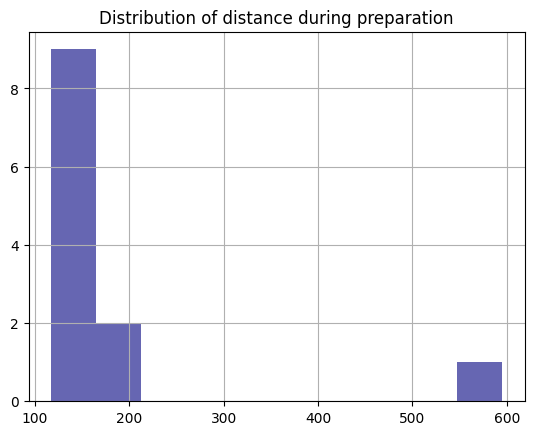

In [40]:
ax = df.kms_during_program.hist(alpha = 0.6, color = 'navy')
ax.set_title('Distribution of distance during preparation')

In [36]:
pd.set_option('display.precision', 2)

In [37]:
df

,races_before,kms_during_program,finished_marathon
0,4,173.86,0
1,1,138.13,1
2,3,159.87,0
3,3,208.95,1
4,1,143.70,1
5,2,136.78,0
6,1,160.42,1
7,1,119.55,1
8,2,162.11,1
9,2,118.74,1


### Average estimations
#### Classic statistics

In [6]:
import numpy as np
from scipy.stats import norm, t

def get_normal_confidence_interval(data, confidence=0.95):
    # Calculate sample mean and standard deviation
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)  # Use ddof=1 for sample standard deviation
    n = len(data)

    # Calculate the critical value (z) based on the confidence level
    z = norm.ppf((1 + confidence) / 2)

    # Calculate the margin of error using standard error
    margin_of_error = z * sample_std / np.sqrt(n)

    # Calculate the confidence interval
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error

    return lower_bound, upper_bound

def get_ttest_confidence_interval(data, confidence=0.95):
    # Calculate sample mean and standard deviation
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)  
    n = len(data)

    # Calculate the critical value (z) based on the confidence level
    z = t.ppf((1 + confidence) / 2, df=len(data) - 1)

    # Calculate the margin of error using standard error
    margin_of_error = z * sample_std / np.sqrt(n)

    # Calculate the confidence interval
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error

    return lower_bound, upper_bound

In [7]:
get_normal_confidence_interval(df.kms_during_program.values)

(111.85768875773665, 260.5477548646436)

In [8]:
get_ttest_confidence_interval(df.kms_during_program.values)

(102.71531297753897, 269.69013064484125)

#### Bootstrap

In [9]:
num_batches = 100

In [10]:
import tqdm
import matplotlib.pyplot as plt

def get_kms_confidence_interval(num_batches):
    tmp = []
    
    for i in tqdm.tqdm(range(num_batches)):
        tmp_df = df.sample(df.shape[0], replace = True)
        tmp.append(
            {
                'iteration': i,
                'mean_kms': tmp_df.kms_during_program.mean()
            }
        )
        
    bootstrap_df = pd.DataFrame(tmp)
        
    lower_bound = bootstrap_df.mean_kms.quantile(0.025)
    upper_bound = bootstrap_df.mean_kms.quantile(0.975)

    ax = bootstrap_df.mean_kms.hist(bins = 50, alpha = 0.6, color = 'purple')
    ax.set_title('Average kms during the program, iterations = %d' % num_batches)
    plt.axvline(x=lower_bound, color='navy', linestyle='--', label='lower bound = %.2f' % lower_bound)
    plt.axvline(x=upper_bound, color='navy', linestyle='--', label='upper bound = %.2f' % upper_bound)
    ax.annotate('CI lower bound: %.2f' % lower_bound, 
                xy=(lower_bound, ax.get_ylim()[1]), 
                xytext=(-10, -20), 
                textcoords='offset points',  
                ha='center', va='top',  
                color='navy', rotation=90) 
    ax.annotate('CI upper bound: %.2f' % upper_bound, 
                xy=(upper_bound, ax.get_ylim()[1]), 
                xytext=(-10, -20), 
                textcoords='offset points',  
                ha='center', va='top',  
                color='navy', rotation=90) 
    # plt.legend() 
    plt.xlim(ax.get_xlim()[0] - 20, ax.get_xlim()[1] + 20)
    plt.show()

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6469.10it/s]


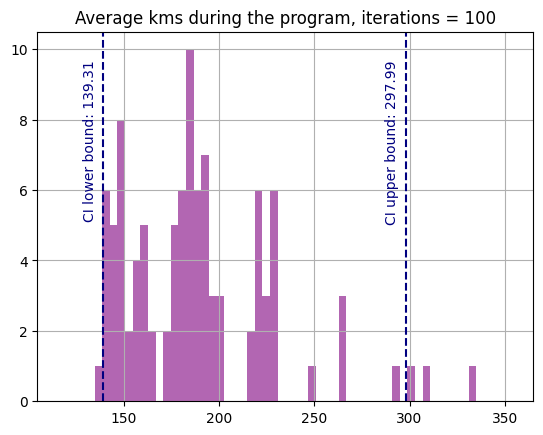

In [11]:
get_kms_confidence_interval(100)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9897.76it/s]


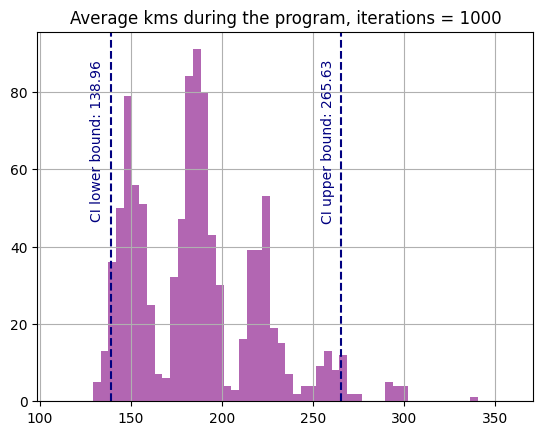

In [12]:
get_kms_confidence_interval(1000)

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13885.97it/s]


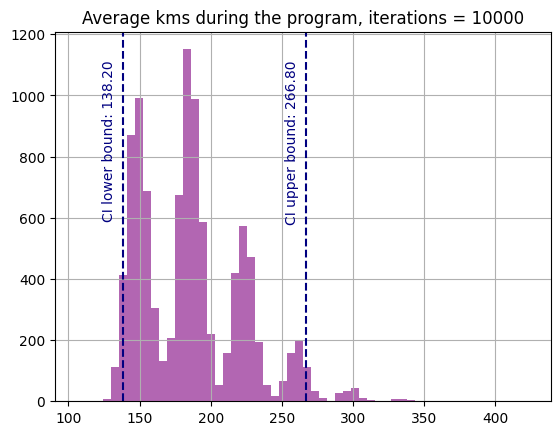

In [13]:
get_kms_confidence_interval(10000)

100%|███████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 14271.37it/s]


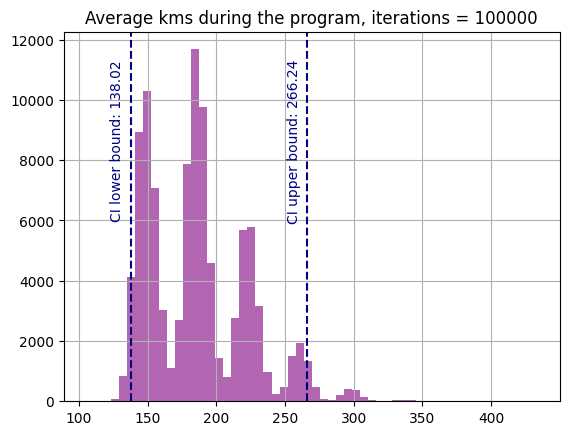

In [14]:
get_kms_confidence_interval(100000)

100%|█████████████████████████████████████████████████████████| 1000000/1000000 [01:10<00:00, 14260.36it/s]


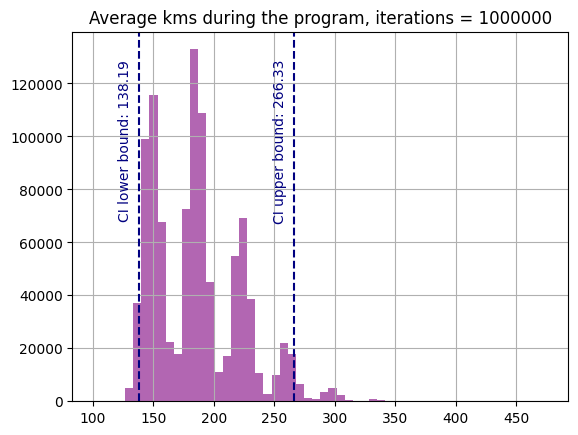

In [15]:
get_kms_confidence_interval(1000000)

### Custom metric

In [16]:
df

,races_before,kms_during_program,finished_marathon
0,4,173.861676,0
1,1,138.134737,1
2,3,159.871705,0
3,3,208.951401,1
4,1,143.698668,1
5,2,136.783006,0
6,1,160.419511,1
7,1,119.551739,1
8,2,162.114497,1
9,2,118.743822,1


In [17]:
import tqdm
import matplotlib.pyplot as plt

def get_refund_share_confidence_interval(num_batches):
    tmp = []
    
    for i in tqdm.tqdm(range(num_batches)):
        tmp_df = df.sample(df.shape[0], replace = True)
        tmp_df['refund'] = list(map(
            lambda kms, passed: 1 if (kms >= 150) and (passed == 0) else 0,
            tmp_df.kms_during_program,
            tmp_df.finished_marathon
        ))
        
        tmp.append(
            {
                'iteration': i,
                'refund_share': tmp_df.refund.mean()
            }
        )
        
    bootstrap_df = pd.DataFrame(tmp)
        
    lower_bound = bootstrap_df.refund_share.quantile(0.025)
    upper_bound = bootstrap_df.refund_share.quantile(0.975)

    ax = bootstrap_df.refund_share.hist(bins = 50, alpha = 0.6, color = 'purple')
    ax.set_title('Share of refunds, iterations = %d' % num_batches)
    plt.axvline(x=lower_bound, color='navy', linestyle='--', label='lower bound = %.2f' % lower_bound)
    plt.axvline(x=upper_bound, color='navy', linestyle='--', label='upper bound = %.2f' % upper_bound)
    ax.annotate('CI lower bound: %.2f' % lower_bound, 
                xy=(lower_bound, ax.get_ylim()[1]), 
                xytext=(-10, -20), 
                textcoords='offset points',  
                ha='center', va='top',  
                color='navy', rotation=90) 
    ax.annotate('CI upper bound: %.2f' % upper_bound, 
                xy=(upper_bound, ax.get_ylim()[1]), 
                xytext=(-10, -20), 
                textcoords='offset points',  
                ha='center', va='top',  
                color='navy', rotation=90) 
    # plt.legend() 
    plt.xlim(-0.1, 1)
    plt.show()

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5546.33it/s]


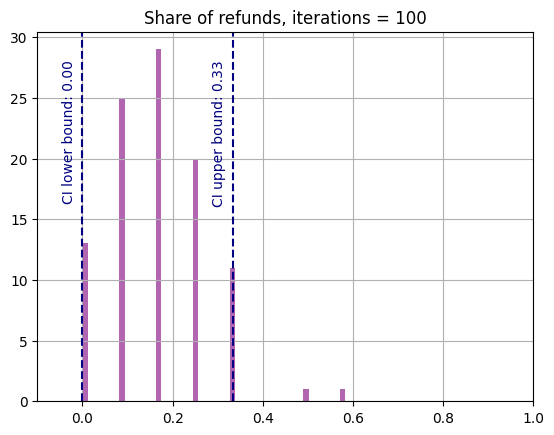

In [18]:
get_refund_share_confidence_interval(100)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5896.85it/s]


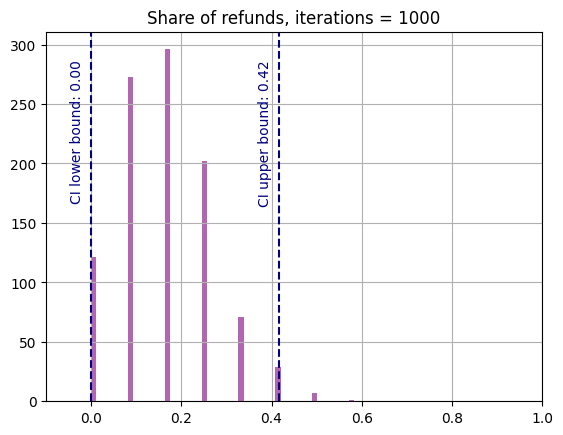

In [19]:
get_refund_share_confidence_interval(1000)

100%|████████████████████████████████████████████████████████████| 100000/100000 [00:36<00:00, 2748.95it/s]


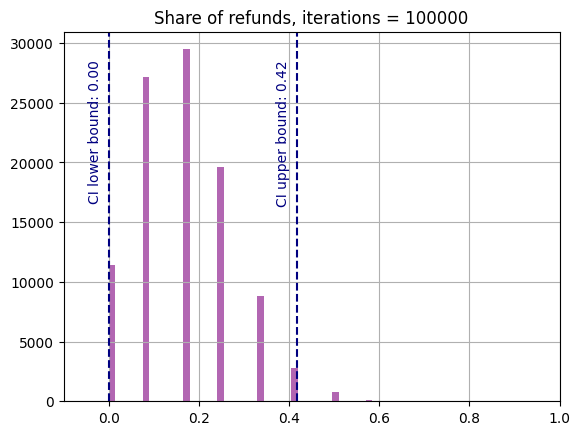

In [41]:
get_refund_share_confidence_interval(100000)

### Regression analysis

In [21]:
import statsmodels.formula.api as smf

In [22]:
model = smf.ols('kms_during_program ~ races_before', data = df).fit()
model.summary().tables[1]

/Users/marie/Documents/github/llm_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,72.4969,13.503,5.369,0.000,42.411,102.583
races_before,41.3476,3.350,12.344,0.000,33.884,48.811


In [23]:
def get_races_coef_confidence_interval(num_batches):
    tmp = []
    
    for i in tqdm.tqdm(range(num_batches)):
        tmp_df = df.sample(df.shape[0], replace = True)
        model = smf.ols('kms_during_program ~ races_before', data = tmp_df).fit()
        
        tmp.append(
            {
                'iteration': i,
                'races_coef': model.params['races_before']
            }
        )
        
    bootstrap_df = pd.DataFrame(tmp)
        
    lower_bound = bootstrap_df.races_coef.quantile(0.025)
    upper_bound = bootstrap_df.races_coef.quantile(0.975)

    ax = bootstrap_df.races_coef.hist(bins = 50, alpha = 0.6, color = 'purple')
    ax.set_title('Coefficient between kms during the program and previous races, iterations = %d' % num_batches)
    plt.axvline(x=lower_bound, color='navy', linestyle='--', label='lower bound = %.2f' % lower_bound)
    plt.axvline(x=upper_bound, color='navy', linestyle='--', label='upper bound = %.2f' % upper_bound)
    ax.annotate('CI lower bound: %.2f' % lower_bound, 
                xy=(lower_bound, ax.get_ylim()[1]), 
                xytext=(-10, -20), 
                textcoords='offset points',  
                ha='center', va='top',  
                color='navy', rotation=90) 
    ax.annotate('CI upper bound: %.2f' % upper_bound, 
                xy=(upper_bound, ax.get_ylim()[1]), 
                xytext=(10, -20), 
                textcoords='offset points',  
                ha='center', va='top',  
                color='navy', rotation=90) 
    # plt.legend() 
    plt.xlim(ax.get_xlim()[0] - 5, ax.get_xlim()[1] + 5)
    plt.show()

    return bootstrap_df

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 663.32it/s]


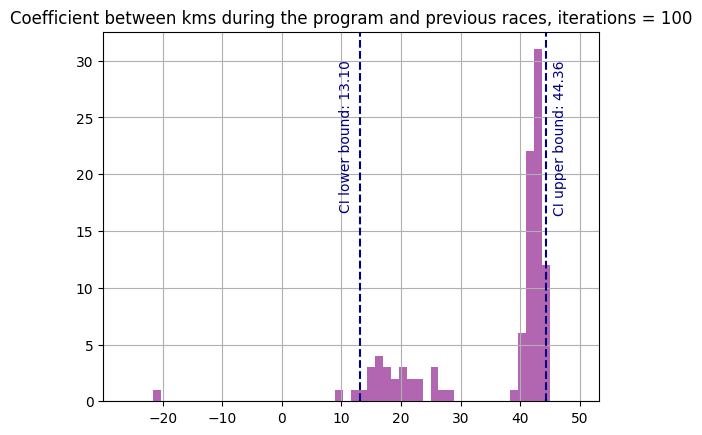

In [24]:
bootstrap100_df = get_races_coef_confidence_interval(100)

100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 662.74it/s]


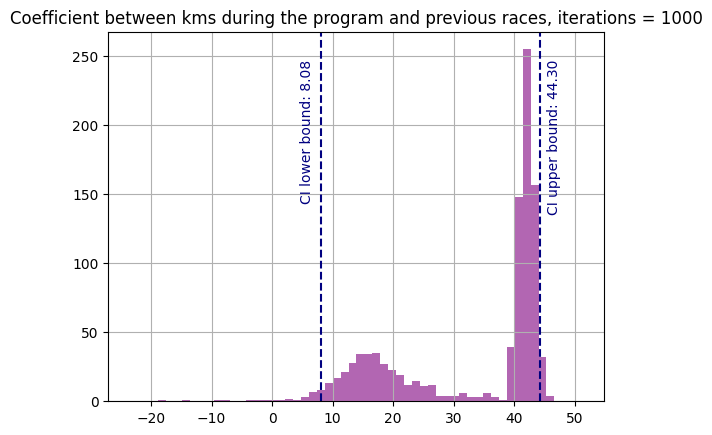

In [25]:
bootstrap1K_df = get_races_coef_confidence_interval(1000)

100%|███████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 666.07it/s]


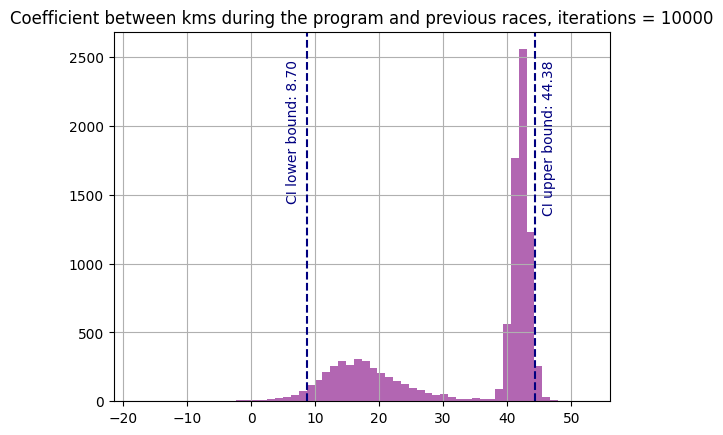

In [26]:
bootstrap10K_df = get_races_coef_confidence_interval(10000)

100%|████████████████████████████████████████████████████████████| 100000/100000 [1:56:36<00:00, 14.29it/s]


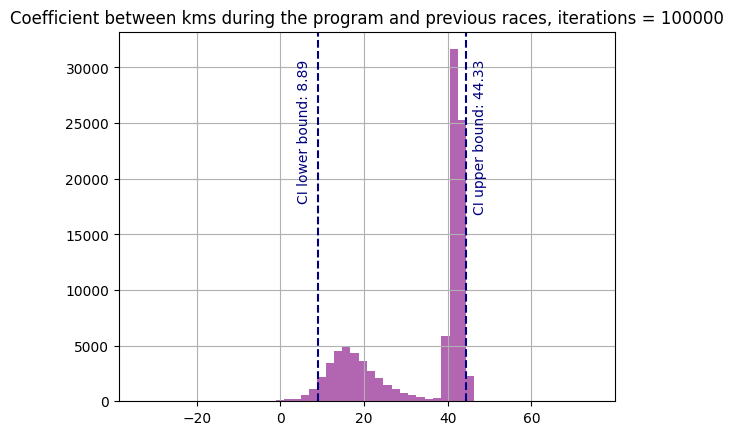

In [27]:
bootstrap100K_df = get_races_coef_confidence_interval(100000)

In [28]:
bootstrap10K_df

,iteration,races_coef
0,0,42.822505
1,1,11.300734
2,2,42.000117
3,3,21.943209
4,4,42.293239
...,...,...
9995,9995,18.233113
9996,9996,44.322909
9997,9997,31.005086
9998,9998,20.593590


In [29]:
bootstrap10K_df[bootstrap10K_df.races_coef <= 0].shape[0]/bootstrap10K_df.shape[0]

0.0039

In [30]:
bootstrap100K_df[bootstrap100K_df.races_coef <= 0].shape[0]/bootstrap100K_df.shape[0]

0.00353